# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
!unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # to make images squared Tensor images of size: image_size x image_size:
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    
    dataset = datasets.ImageFolder(data_dir, transform)
    
    dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
    
    return dataloader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

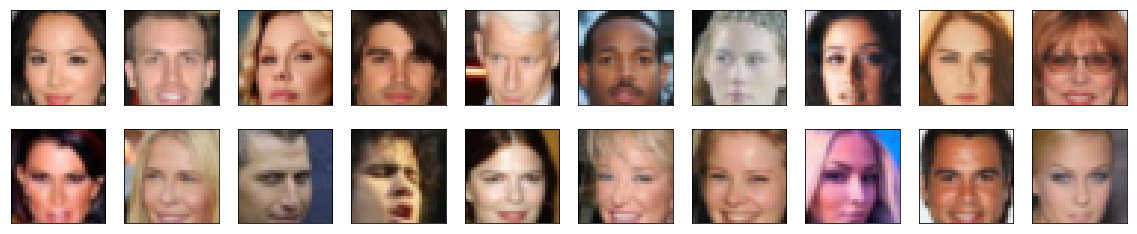

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(0.9922)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)      

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        #fully connected
        out = self.fc(x)
        #reshape
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = torch.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
#     if classname.find('Conv') or classname.find('Linear'):
#         m.weight.data.normal_(0, 0.02)
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.rand(batch_size)*0.9 
    
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
        
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels
    
    # move labels to GPU if available
    if train_on_gpu:
        labels = labels.cuda()
        
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

lr = 0.001
beta1 = 0.1
beta2 = 0.9

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            #-----
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z).detach()

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            
            
            # 2. Train the generator with an adversarial loss
            g_loss = g_optimizer.zero_grad()
            
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
                                    
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 40


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   40] | d_loss: 1.3928 | g_loss: 1.1122
Epoch [    1/   40] | d_loss: 1.0276 | g_loss: 0.7182
Epoch [    1/   40] | d_loss: 1.0978 | g_loss: 1.0748
Epoch [    1/   40] | d_loss: 1.1021 | g_loss: 0.9925
Epoch [    1/   40] | d_loss: 1.1466 | g_loss: 0.7644
Epoch [    1/   40] | d_loss: 1.0421 | g_loss: 0.8276
Epoch [    1/   40] | d_loss: 1.0351 | g_loss: 0.9447
Epoch [    1/   40] | d_loss: 1.0361 | g_loss: 0.9539
Epoch [    1/   40] | d_loss: 1.0244 | g_loss: 0.9180
Epoch [    1/   40] | d_loss: 0.9523 | g_loss: 0.9828
Epoch [    1/   40] | d_loss: 1.0490 | g_loss: 0.9792
Epoch [    1/   40] | d_loss: 0.9994 | g_loss: 0.8549
Epoch [    1/   40] | d_loss: 1.0774 | g_loss: 0.7807
Epoch [    1/   40] | d_loss: 1.2114 | g_loss: 0.8551
Epoch [    1/   40] | d_loss: 0.9968 | g_loss: 1.1693
Epoch [    1/   40] | d_loss: 1.0783 | g_loss: 0.8424
Epoch [    1/   40] | d_loss: 0.9948 | g_loss: 0.7619
Epoch [    1/   40] | d_loss: 1.0099 | g_loss: 0.8214
Epoch [    1/   40] | d_loss

Epoch [    3/   40] | d_loss: 0.9263 | g_loss: 1.1192
Epoch [    3/   40] | d_loss: 1.1097 | g_loss: 0.9192
Epoch [    3/   40] | d_loss: 1.0591 | g_loss: 0.8270
Epoch [    3/   40] | d_loss: 1.0382 | g_loss: 0.9594
Epoch [    3/   40] | d_loss: 0.9391 | g_loss: 1.0874
Epoch [    3/   40] | d_loss: 1.0324 | g_loss: 0.9730
Epoch [    3/   40] | d_loss: 0.9824 | g_loss: 0.9827
Epoch [    3/   40] | d_loss: 0.9927 | g_loss: 0.8510
Epoch [    3/   40] | d_loss: 1.0222 | g_loss: 0.8522
Epoch [    3/   40] | d_loss: 1.0399 | g_loss: 0.9806
Epoch [    3/   40] | d_loss: 0.8924 | g_loss: 0.9031
Epoch [    3/   40] | d_loss: 1.0789 | g_loss: 1.1272
Epoch [    3/   40] | d_loss: 0.9601 | g_loss: 1.0036
Epoch [    3/   40] | d_loss: 1.0462 | g_loss: 1.0265
Epoch [    3/   40] | d_loss: 1.0115 | g_loss: 0.8609
Epoch [    3/   40] | d_loss: 1.0473 | g_loss: 1.0235
Epoch [    3/   40] | d_loss: 0.9549 | g_loss: 0.8057
Epoch [    3/   40] | d_loss: 0.8857 | g_loss: 0.9179
Epoch [    3/   40] | d_loss

Epoch [    6/   40] | d_loss: 0.9291 | g_loss: 1.0344
Epoch [    6/   40] | d_loss: 0.9419 | g_loss: 0.8816
Epoch [    6/   40] | d_loss: 0.9377 | g_loss: 0.7991
Epoch [    6/   40] | d_loss: 1.0159 | g_loss: 0.8661
Epoch [    6/   40] | d_loss: 0.9645 | g_loss: 0.9796
Epoch [    6/   40] | d_loss: 1.0354 | g_loss: 0.9895
Epoch [    6/   40] | d_loss: 0.9325 | g_loss: 1.0598
Epoch [    6/   40] | d_loss: 1.0343 | g_loss: 1.2985
Epoch [    6/   40] | d_loss: 0.9356 | g_loss: 0.9230
Epoch [    6/   40] | d_loss: 1.1119 | g_loss: 1.3331
Epoch [    6/   40] | d_loss: 1.0304 | g_loss: 0.9343
Epoch [    6/   40] | d_loss: 1.0569 | g_loss: 0.9370
Epoch [    6/   40] | d_loss: 1.0846 | g_loss: 0.7750
Epoch [    6/   40] | d_loss: 1.0125 | g_loss: 0.8433
Epoch [    6/   40] | d_loss: 1.2270 | g_loss: 0.8629
Epoch [    6/   40] | d_loss: 0.9400 | g_loss: 0.8798
Epoch [    6/   40] | d_loss: 1.0287 | g_loss: 1.1028
Epoch [    6/   40] | d_loss: 0.9143 | g_loss: 1.3290
Epoch [    6/   40] | d_loss

Epoch [    9/   40] | d_loss: 0.9647 | g_loss: 1.0317
Epoch [    9/   40] | d_loss: 0.9628 | g_loss: 0.9811
Epoch [    9/   40] | d_loss: 0.9042 | g_loss: 0.9303
Epoch [    9/   40] | d_loss: 0.9328 | g_loss: 1.0548
Epoch [    9/   40] | d_loss: 0.8633 | g_loss: 1.1517
Epoch [    9/   40] | d_loss: 0.9211 | g_loss: 0.9318
Epoch [    9/   40] | d_loss: 0.9159 | g_loss: 1.5739
Epoch [    9/   40] | d_loss: 1.1360 | g_loss: 0.8227
Epoch [    9/   40] | d_loss: 0.9618 | g_loss: 0.9981
Epoch [    9/   40] | d_loss: 0.8474 | g_loss: 1.0980
Epoch [    9/   40] | d_loss: 0.8610 | g_loss: 1.3610
Epoch [    9/   40] | d_loss: 0.9979 | g_loss: 1.0895
Epoch [    9/   40] | d_loss: 1.0162 | g_loss: 1.0794
Epoch [    9/   40] | d_loss: 1.0209 | g_loss: 1.1391
Epoch [    9/   40] | d_loss: 0.8477 | g_loss: 1.0858
Epoch [    9/   40] | d_loss: 0.9035 | g_loss: 1.1315
Epoch [    9/   40] | d_loss: 0.9115 | g_loss: 1.2108
Epoch [    9/   40] | d_loss: 0.9718 | g_loss: 1.0043
Epoch [    9/   40] | d_loss

Epoch [   11/   40] | d_loss: 0.9606 | g_loss: 1.0583
Epoch [   11/   40] | d_loss: 0.7995 | g_loss: 1.0551
Epoch [   11/   40] | d_loss: 0.9689 | g_loss: 1.2938
Epoch [   11/   40] | d_loss: 0.8605 | g_loss: 1.1134
Epoch [   11/   40] | d_loss: 0.9731 | g_loss: 1.1161
Epoch [   11/   40] | d_loss: 0.9002 | g_loss: 1.1981
Epoch [   11/   40] | d_loss: 0.8701 | g_loss: 0.9381
Epoch [   11/   40] | d_loss: 1.0180 | g_loss: 1.0608
Epoch [   11/   40] | d_loss: 0.9622 | g_loss: 0.9838
Epoch [   11/   40] | d_loss: 0.9335 | g_loss: 1.6821
Epoch [   11/   40] | d_loss: 0.9621 | g_loss: 1.4497
Epoch [   11/   40] | d_loss: 0.8881 | g_loss: 1.0113
Epoch [   11/   40] | d_loss: 0.8651 | g_loss: 1.2617
Epoch [   11/   40] | d_loss: 1.0071 | g_loss: 0.8928
Epoch [   11/   40] | d_loss: 1.0793 | g_loss: 1.2146
Epoch [   11/   40] | d_loss: 0.9674 | g_loss: 0.7774
Epoch [   11/   40] | d_loss: 0.8993 | g_loss: 0.8271
Epoch [   11/   40] | d_loss: 0.9534 | g_loss: 1.0892
Epoch [   11/   40] | d_loss

Epoch [   14/   40] | d_loss: 0.8556 | g_loss: 1.2604
Epoch [   14/   40] | d_loss: 0.8478 | g_loss: 0.9276
Epoch [   14/   40] | d_loss: 0.9027 | g_loss: 1.0060
Epoch [   14/   40] | d_loss: 0.8053 | g_loss: 1.1247
Epoch [   14/   40] | d_loss: 0.7975 | g_loss: 1.3292
Epoch [   14/   40] | d_loss: 1.0298 | g_loss: 0.9088
Epoch [   14/   40] | d_loss: 0.7935 | g_loss: 1.0041
Epoch [   14/   40] | d_loss: 0.8547 | g_loss: 1.3406
Epoch [   14/   40] | d_loss: 0.9015 | g_loss: 1.0640
Epoch [   14/   40] | d_loss: 0.8789 | g_loss: 1.4390
Epoch [   14/   40] | d_loss: 0.8465 | g_loss: 1.0529
Epoch [   14/   40] | d_loss: 0.8837 | g_loss: 1.1761
Epoch [   14/   40] | d_loss: 0.8693 | g_loss: 1.2793
Epoch [   14/   40] | d_loss: 0.9076 | g_loss: 0.8067
Epoch [   14/   40] | d_loss: 0.8264 | g_loss: 1.2322
Epoch [   14/   40] | d_loss: 0.9181 | g_loss: 0.8482
Epoch [   14/   40] | d_loss: 0.8556 | g_loss: 1.1640
Epoch [   14/   40] | d_loss: 1.1419 | g_loss: 0.9984
Epoch [   14/   40] | d_loss

Epoch [   17/   40] | d_loss: 1.1211 | g_loss: 1.4224
Epoch [   17/   40] | d_loss: 0.9582 | g_loss: 1.0958
Epoch [   17/   40] | d_loss: 0.8999 | g_loss: 1.3271
Epoch [   17/   40] | d_loss: 0.9947 | g_loss: 1.6775
Epoch [   17/   40] | d_loss: 0.8724 | g_loss: 1.0321
Epoch [   17/   40] | d_loss: 0.8609 | g_loss: 1.3049
Epoch [   17/   40] | d_loss: 0.8907 | g_loss: 0.9958
Epoch [   17/   40] | d_loss: 0.9550 | g_loss: 1.0253
Epoch [   17/   40] | d_loss: 0.8550 | g_loss: 1.1101
Epoch [   17/   40] | d_loss: 0.8300 | g_loss: 1.3631
Epoch [   17/   40] | d_loss: 0.7979 | g_loss: 1.4159
Epoch [   17/   40] | d_loss: 0.8876 | g_loss: 0.8795
Epoch [   17/   40] | d_loss: 0.8793 | g_loss: 0.9667
Epoch [   17/   40] | d_loss: 1.1034 | g_loss: 1.7887
Epoch [   17/   40] | d_loss: 0.8358 | g_loss: 1.2386
Epoch [   17/   40] | d_loss: 0.8784 | g_loss: 0.8878
Epoch [   17/   40] | d_loss: 0.8618 | g_loss: 1.1078
Epoch [   17/   40] | d_loss: 0.8607 | g_loss: 1.3139
Epoch [   17/   40] | d_loss

Epoch [   19/   40] | d_loss: 0.9733 | g_loss: 0.9699
Epoch [   19/   40] | d_loss: 0.9095 | g_loss: 1.2360
Epoch [   19/   40] | d_loss: 0.8488 | g_loss: 1.4246
Epoch [   19/   40] | d_loss: 0.9176 | g_loss: 1.3765
Epoch [   19/   40] | d_loss: 0.9059 | g_loss: 1.1676
Epoch [   19/   40] | d_loss: 0.8404 | g_loss: 1.1787
Epoch [   19/   40] | d_loss: 0.9310 | g_loss: 1.3363
Epoch [   19/   40] | d_loss: 0.8139 | g_loss: 1.4884
Epoch [   19/   40] | d_loss: 0.9015 | g_loss: 1.2286
Epoch [   19/   40] | d_loss: 0.8545 | g_loss: 1.0770
Epoch [   19/   40] | d_loss: 0.9085 | g_loss: 1.4802
Epoch [   19/   40] | d_loss: 1.0159 | g_loss: 1.3277
Epoch [   19/   40] | d_loss: 0.8840 | g_loss: 0.9113
Epoch [   19/   40] | d_loss: 0.9741 | g_loss: 1.3012
Epoch [   19/   40] | d_loss: 0.8417 | g_loss: 1.1807
Epoch [   19/   40] | d_loss: 0.8877 | g_loss: 1.3689
Epoch [   19/   40] | d_loss: 0.9113 | g_loss: 1.1773
Epoch [   19/   40] | d_loss: 0.8245 | g_loss: 1.1049
Epoch [   19/   40] | d_loss

Epoch [   22/   40] | d_loss: 0.7819 | g_loss: 1.4196
Epoch [   22/   40] | d_loss: 0.8528 | g_loss: 1.2922
Epoch [   22/   40] | d_loss: 0.9297 | g_loss: 1.0324
Epoch [   22/   40] | d_loss: 0.8792 | g_loss: 1.0097
Epoch [   22/   40] | d_loss: 1.0322 | g_loss: 1.2322
Epoch [   22/   40] | d_loss: 0.8145 | g_loss: 1.2243
Epoch [   22/   40] | d_loss: 0.8665 | g_loss: 1.2536
Epoch [   22/   40] | d_loss: 0.8735 | g_loss: 0.8735
Epoch [   22/   40] | d_loss: 0.8428 | g_loss: 1.2357
Epoch [   22/   40] | d_loss: 0.8337 | g_loss: 1.4592
Epoch [   22/   40] | d_loss: 0.8671 | g_loss: 1.2542
Epoch [   22/   40] | d_loss: 0.9932 | g_loss: 0.9235
Epoch [   22/   40] | d_loss: 0.8345 | g_loss: 1.3232
Epoch [   22/   40] | d_loss: 0.7475 | g_loss: 1.1954
Epoch [   22/   40] | d_loss: 0.9165 | g_loss: 1.4017
Epoch [   22/   40] | d_loss: 0.7859 | g_loss: 1.3243
Epoch [   22/   40] | d_loss: 1.0322 | g_loss: 1.2823
Epoch [   22/   40] | d_loss: 0.7955 | g_loss: 1.1684
Epoch [   22/   40] | d_loss

Epoch [   25/   40] | d_loss: 0.9246 | g_loss: 1.1463
Epoch [   25/   40] | d_loss: 0.8023 | g_loss: 1.3932
Epoch [   25/   40] | d_loss: 0.9857 | g_loss: 1.2771
Epoch [   25/   40] | d_loss: 0.9279 | g_loss: 0.8098
Epoch [   25/   40] | d_loss: 0.8853 | g_loss: 1.4415
Epoch [   25/   40] | d_loss: 0.9492 | g_loss: 1.2389
Epoch [   25/   40] | d_loss: 0.9238 | g_loss: 1.0800
Epoch [   25/   40] | d_loss: 0.8960 | g_loss: 1.4007
Epoch [   25/   40] | d_loss: 0.8043 | g_loss: 1.4118
Epoch [   25/   40] | d_loss: 0.9059 | g_loss: 1.7723
Epoch [   25/   40] | d_loss: 0.8251 | g_loss: 1.2208
Epoch [   25/   40] | d_loss: 0.8919 | g_loss: 1.1572
Epoch [   25/   40] | d_loss: 0.9002 | g_loss: 1.0645
Epoch [   25/   40] | d_loss: 0.9395 | g_loss: 1.3288
Epoch [   25/   40] | d_loss: 1.2200 | g_loss: 0.8198
Epoch [   25/   40] | d_loss: 0.8112 | g_loss: 1.2002
Epoch [   25/   40] | d_loss: 0.8820 | g_loss: 1.3542
Epoch [   25/   40] | d_loss: 0.8265 | g_loss: 1.2081
Epoch [   25/   40] | d_loss

Epoch [   27/   40] | d_loss: 0.8567 | g_loss: 1.3225
Epoch [   27/   40] | d_loss: 0.7754 | g_loss: 1.1856
Epoch [   27/   40] | d_loss: 0.9450 | g_loss: 0.9218
Epoch [   27/   40] | d_loss: 0.9271 | g_loss: 1.2874
Epoch [   27/   40] | d_loss: 0.8297 | g_loss: 1.1569
Epoch [   27/   40] | d_loss: 0.8922 | g_loss: 1.1412
Epoch [   27/   40] | d_loss: 0.9231 | g_loss: 1.2603
Epoch [   27/   40] | d_loss: 1.0608 | g_loss: 0.9534
Epoch [   27/   40] | d_loss: 0.9191 | g_loss: 1.0685
Epoch [   27/   40] | d_loss: 0.8308 | g_loss: 1.3468
Epoch [   27/   40] | d_loss: 0.8387 | g_loss: 1.3275
Epoch [   27/   40] | d_loss: 0.8260 | g_loss: 1.6144
Epoch [   27/   40] | d_loss: 0.8965 | g_loss: 1.0885
Epoch [   27/   40] | d_loss: 0.7745 | g_loss: 1.3929
Epoch [   27/   40] | d_loss: 0.9750 | g_loss: 1.0755
Epoch [   27/   40] | d_loss: 0.8886 | g_loss: 0.9403
Epoch [   27/   40] | d_loss: 0.9022 | g_loss: 1.3654
Epoch [   27/   40] | d_loss: 0.8747 | g_loss: 1.1834
Epoch [   27/   40] | d_loss

Epoch [   30/   40] | d_loss: 0.8659 | g_loss: 1.1843
Epoch [   30/   40] | d_loss: 0.8547 | g_loss: 1.3321
Epoch [   30/   40] | d_loss: 0.7973 | g_loss: 1.3758
Epoch [   30/   40] | d_loss: 0.8500 | g_loss: 1.0316
Epoch [   30/   40] | d_loss: 1.0475 | g_loss: 1.6763
Epoch [   30/   40] | d_loss: 0.8874 | g_loss: 1.0490
Epoch [   30/   40] | d_loss: 0.8888 | g_loss: 1.1488
Epoch [   30/   40] | d_loss: 0.8443 | g_loss: 1.3191
Epoch [   30/   40] | d_loss: 0.9147 | g_loss: 1.4984
Epoch [   30/   40] | d_loss: 1.0476 | g_loss: 0.9840
Epoch [   30/   40] | d_loss: 0.8941 | g_loss: 1.3168
Epoch [   30/   40] | d_loss: 0.8889 | g_loss: 1.3006
Epoch [   30/   40] | d_loss: 0.9088 | g_loss: 1.1895
Epoch [   30/   40] | d_loss: 0.9252 | g_loss: 1.3593
Epoch [   30/   40] | d_loss: 0.8148 | g_loss: 1.5185
Epoch [   30/   40] | d_loss: 0.8898 | g_loss: 0.9266
Epoch [   30/   40] | d_loss: 1.0367 | g_loss: 1.2087
Epoch [   30/   40] | d_loss: 1.0575 | g_loss: 1.6968
Epoch [   30/   40] | d_loss

Epoch [   33/   40] | d_loss: 0.7975 | g_loss: 1.1743
Epoch [   33/   40] | d_loss: 0.8331 | g_loss: 1.6163
Epoch [   33/   40] | d_loss: 0.8039 | g_loss: 1.3341
Epoch [   33/   40] | d_loss: 0.8702 | g_loss: 1.6132
Epoch [   33/   40] | d_loss: 0.8876 | g_loss: 0.9554
Epoch [   33/   40] | d_loss: 1.0300 | g_loss: 1.0524
Epoch [   33/   40] | d_loss: 0.7471 | g_loss: 1.7035
Epoch [   33/   40] | d_loss: 0.8406 | g_loss: 1.3180
Epoch [   33/   40] | d_loss: 0.9117 | g_loss: 1.4695
Epoch [   33/   40] | d_loss: 0.7725 | g_loss: 1.3221
Epoch [   33/   40] | d_loss: 0.8539 | g_loss: 1.1629
Epoch [   33/   40] | d_loss: 0.9098 | g_loss: 0.9759
Epoch [   33/   40] | d_loss: 0.8643 | g_loss: 1.3460
Epoch [   33/   40] | d_loss: 0.8126 | g_loss: 1.2709
Epoch [   33/   40] | d_loss: 0.7938 | g_loss: 1.8367
Epoch [   33/   40] | d_loss: 0.9032 | g_loss: 1.4190
Epoch [   33/   40] | d_loss: 0.9160 | g_loss: 1.1278
Epoch [   33/   40] | d_loss: 0.8986 | g_loss: 1.3128
Epoch [   33/   40] | d_loss

Epoch [   35/   40] | d_loss: 0.9424 | g_loss: 1.7043
Epoch [   35/   40] | d_loss: 0.9491 | g_loss: 1.3899
Epoch [   35/   40] | d_loss: 0.7901 | g_loss: 1.2616
Epoch [   35/   40] | d_loss: 0.9498 | g_loss: 2.2350
Epoch [   35/   40] | d_loss: 0.8422 | g_loss: 1.1956
Epoch [   35/   40] | d_loss: 0.7986 | g_loss: 1.6082
Epoch [   35/   40] | d_loss: 0.8367 | g_loss: 1.4200
Epoch [   35/   40] | d_loss: 0.8895 | g_loss: 1.8592
Epoch [   35/   40] | d_loss: 0.8556 | g_loss: 1.1467
Epoch [   35/   40] | d_loss: 0.9484 | g_loss: 1.1068
Epoch [   35/   40] | d_loss: 0.9595 | g_loss: 1.0886
Epoch [   35/   40] | d_loss: 0.8272 | g_loss: 1.0347
Epoch [   35/   40] | d_loss: 0.9001 | g_loss: 1.5529
Epoch [   35/   40] | d_loss: 0.9052 | g_loss: 1.3063
Epoch [   35/   40] | d_loss: 1.1063 | g_loss: 1.6425
Epoch [   35/   40] | d_loss: 0.8334 | g_loss: 1.5887
Epoch [   35/   40] | d_loss: 0.8635 | g_loss: 1.0380
Epoch [   35/   40] | d_loss: 1.0075 | g_loss: 1.4974
Epoch [   35/   40] | d_loss

Epoch [   38/   40] | d_loss: 0.8919 | g_loss: 1.2245
Epoch [   38/   40] | d_loss: 0.9822 | g_loss: 1.6701
Epoch [   38/   40] | d_loss: 0.8498 | g_loss: 1.0059
Epoch [   38/   40] | d_loss: 0.8930 | g_loss: 1.1960
Epoch [   38/   40] | d_loss: 0.9031 | g_loss: 1.6616
Epoch [   38/   40] | d_loss: 0.7925 | g_loss: 1.4840
Epoch [   38/   40] | d_loss: 0.9036 | g_loss: 1.2114
Epoch [   38/   40] | d_loss: 0.8253 | g_loss: 1.4191
Epoch [   38/   40] | d_loss: 0.8392 | g_loss: 1.2493
Epoch [   38/   40] | d_loss: 0.8823 | g_loss: 1.3156
Epoch [   38/   40] | d_loss: 0.8254 | g_loss: 1.4145
Epoch [   38/   40] | d_loss: 1.0105 | g_loss: 1.2016
Epoch [   38/   40] | d_loss: 0.8122 | g_loss: 1.3933
Epoch [   38/   40] | d_loss: 0.8453 | g_loss: 1.1114
Epoch [   38/   40] | d_loss: 0.9057 | g_loss: 1.2051
Epoch [   38/   40] | d_loss: 0.8450 | g_loss: 1.1924
Epoch [   38/   40] | d_loss: 0.8412 | g_loss: 2.0219
Epoch [   38/   40] | d_loss: 0.8821 | g_loss: 1.7927
Epoch [   38/   40] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

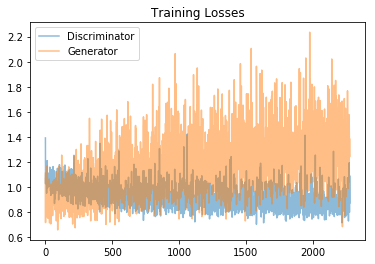

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

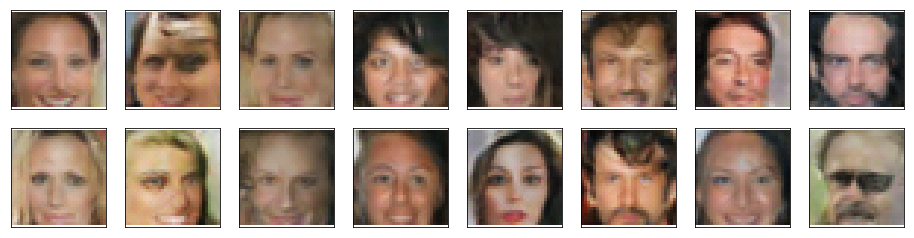

In [25]:
_ = view_samples(-1, samples)

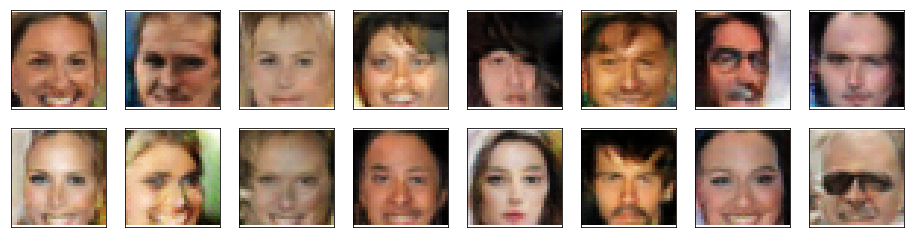

In [29]:
_ = view_samples(10, samples)

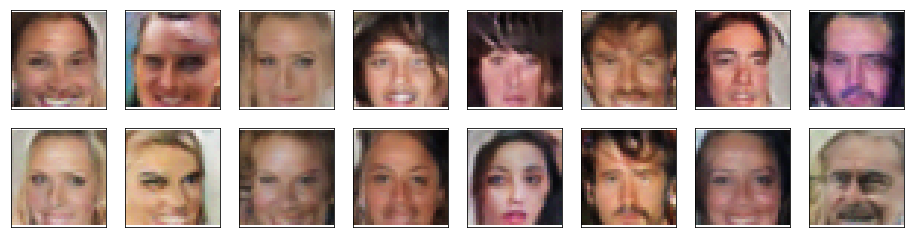

In [31]:
_ = view_samples(30, samples)

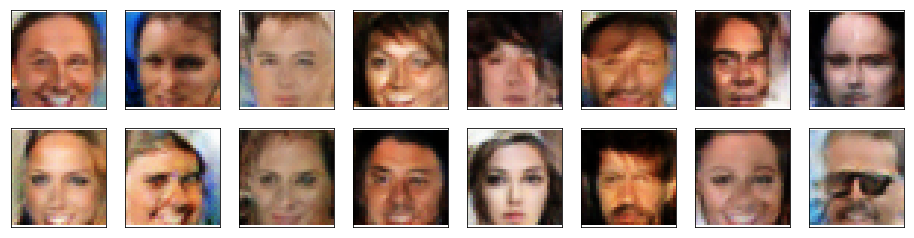

In [33]:
_ = view_samples(5, samples)

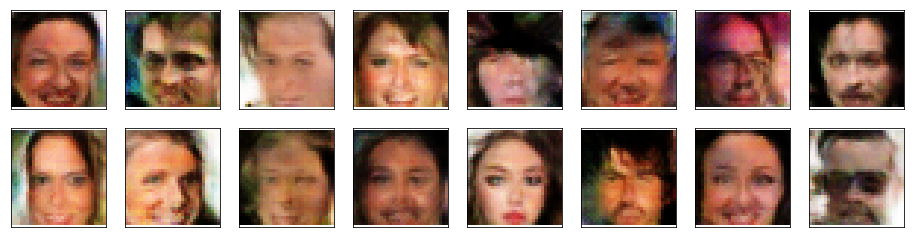

In [35]:
_ = view_samples(1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**(Answer:)** 

**biased** - majority of the images are for white females.

**size** - it have to be larger to learn more features.

**optimizer** - i used Adam since it is preferred for this task.

I made the training on 30 epochs but the generated images were showing a bad quality so i increased the epochs number to 40 and changed the beta values, also i changed the batc size and the and the image size

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.